In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

## The Walmart dataset

In 2014, Walmart released some of its sales data as part of a competition to predict the weekly sales of its stores. We've taken a subset of their data and loaded it below.

In [59]:
walmart = pd.read_csv('walmart.csv')
walmart

,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,Unemployment,MarkDown
0,2010-02-05,24924.50,No,42.31,2.572,8.106,No Markdown
1,2010-02-12,46039.49,Yes,38.51,2.548,8.106,No Markdown
2,2010-02-19,41595.55,No,39.93,2.514,8.106,No Markdown
...,...,...,...,...,...,...,...
140,2012-10-12,22764.01,No,62.99,3.601,6.573,MarkDown2
141,2012-10-19,24185.27,No,67.97,3.594,6.573,MarkDown2
142,2012-10-26,27390.81,No,69.16,3.506,6.573,MarkDown1


The data contains several interesting features, including whether a week contained a holiday (`IsHoliday`), the unemployment rate that week (`Unemployment`), and which special deals the store offered that week (`MarkDown`).

Our goal is to create a model that predicts the `Weekly_Sales` variable using the other variables in our data. Using a linear regression model we directly can use the `Temperature`, `Fuel_Price`, and `Unemployment` columns because they contain numerical data.

## Fitting a Model Using Scikit-Learn

In previous sections we have seen how to take the gradient of the cost function and use gradient descent to fit a model. To do this, we had to define Python functions for our model, the cost function, the gradient of the cost function, and the gradient descent algorithm. While this was important to demonstrate how the concepts work, in this section we will instead use a machine learning library called [`scikit-learn`](http://scikit-learn.org/) which allows us to fit a model with less code.

For example, to fit a multiple linear regression model using the numerical columns in the Walmart dataset, we first create a two-dimensional NumPy array containing the variables used for prediction and a one-dimensional array containing the values we want to predict:

In [77]:
numerical_columns = ['Temperature', 'Fuel_Price', 'Unemployment']
X = walmart[numerical_columns].as_matrix()
X

array([[ 42.31,   2.57,   8.11],
       [ 38.51,   2.55,   8.11],
       [ 39.93,   2.51,   8.11],
       ..., 
       [ 62.99,   3.6 ,   6.57],
       [ 67.97,   3.59,   6.57],
       [ 69.16,   3.51,   6.57]])

In [78]:
y = walmart['Weekly_Sales'].as_matrix()
y

array([ 24924.5 ,  46039.49,  41595.55, ...,  22764.01,  24185.27,
        27390.81])

Then, we import the `LinearRegression` class from `scikit-learn` ([docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)), instantiate it, and call the `fit` method using `X` to predict `y`.

Note that previously we had to manually add a column of all $1$'s to the `X` matrix in order to conduct linear regression with an intercept. This time, `scikit-learn` will take care of the intercept column behind the scenes, saving us some work.

In [79]:
from sklearn.linear_model import LinearRegression

simple_classifier = LinearRegression()
simple_classifier.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We are done! When we called `.fit`, `scikit-learn` found the linear regression parameters that minimized the least squares cost function. We can see the parameters below:

In [80]:
simple_classifier.coef_, simple_classifier.intercept_

(array([ -332.22,  1626.63,  1356.87]), 29642.700510138635)

To calculate the mean squared cost, we can ask the classifier to make predictions for the input data `X` and compare the predictions with the actual values `y`.

In [81]:
predictions = simple_classifier.predict(X)
np.mean((predictions - y) ** 2)

74401210.603607252

The mean squared error looks quite high. This is likely because our variables (temperature, price of fuel, and unemployment rate) are only weakly correlated with the weekly sales.

There are two more variables in our data that might be more useful for prediction: the `IsHoliday` column and `MarkDown` column. The boxplot below shows that holidays may have some relation with the weekly sales.

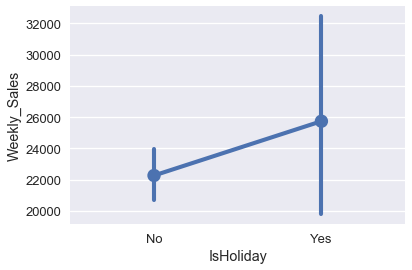

In [174]:
sns.pointplot(x='IsHoliday', y='Weekly_Sales', data=walmart);

The different markdown categories seem to correlate with different weekly sale amounts well.

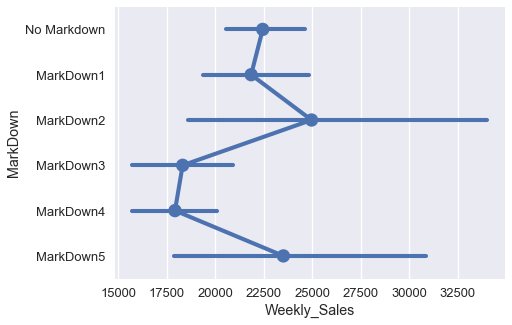

In [61]:
markdowns = ['No Markdown', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
plt.figure(figsize=(7, 5))
sns.pointplot(x='Weekly_Sales', y='MarkDown', data=walmart, order=markdowns);

However, both `IsHoliday` and `MarkDown` columns contain categorical data, not numerical, so we cannot use them as-is for regression.

## The One-Hot Encoding

Fortunately, we can perform a **one-hot encoding** transformation on these categorical variables to convert them into numerical variables. The transformation works as follows: create a new column for every unique value in a categorical variable. The column contains a $1$ if the variable originally had the corresponding value, otherwise the column contains a $0$. For example, the `MarkDown` column below contains the following values:

In [62]:
# HIDDEN
walmart[['MarkDown']]

,MarkDown
0,No Markdown
1,No Markdown
2,No Markdown
...,...
140,MarkDown2
141,MarkDown2
142,MarkDown1


This variable contains six different unique values: 'No Markdown', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', and 'MarkDown5'. We create one column for each value to get six columns in total. Then, we fill in the columns with zeros and ones according the scheme described above.

In [63]:
# HIDDEN
from sklearn.feature_extraction import DictVectorizer

items = walmart[['MarkDown']].to_dict(orient='records')
encoder = DictVectorizer(sparse=False)
pd.DataFrame(
    data=encoder.fit_transform(items),
    columns=encoder.feature_names_
)

,MarkDown=MarkDown1,MarkDown=MarkDown2,MarkDown=MarkDown3,MarkDown=MarkDown4,MarkDown=MarkDown5,MarkDown=No Markdown
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
140,0.0,1.0,0.0,0.0,0.0,0.0
141,0.0,1.0,0.0,0.0,0.0,0.0
142,1.0,0.0,0.0,0.0,0.0,0.0


Notice that the first value in the data is "No Markdown", and thus only the last column of the first row in the transformed table is marked with $1$. In addition, the last value in the data is "MarkDown1" which results in the first column of row 142 marked as $1$.

Each row of the resulting table will contain a single column containing $1$; the rest will contain $0$. The name "one-hot" reflects the fact that only one column is "hot" (marked with a $1$).

## One-Hot Encoding in Scikit-Learn

To perform one-hot encoding we can use `scikit-learn`'s [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) class. To use the class, we have to convert our dataframe into a list of dictionaries. The DictVectorizer class automatically one-hot encodes the categorical data (which needs to be strings) and leaves numerical data untouched.

In [152]:
from sklearn.feature_extraction import DictVectorizer

all_columns = ['Temperature', 'Fuel_Price', 'Unemployment', 'IsHoliday',
               'MarkDown']

records = walmart[all_columns].to_dict(orient='records')
encoder = DictVectorizer(sparse=False)
encoded_X = encoder.fit_transform(records)
encoded_X

array([[  2.57,   1.  ,   0.  , ...,   1.  ,  42.31,   8.11],
       [  2.55,   0.  ,   1.  , ...,   1.  ,  38.51,   8.11],
       [  2.51,   1.  ,   0.  , ...,   1.  ,  39.93,   8.11],
       ..., 
       [  3.6 ,   1.  ,   0.  , ...,   0.  ,  62.99,   6.57],
       [  3.59,   1.  ,   0.  , ...,   0.  ,  67.97,   6.57],
       [  3.51,   1.  ,   0.  , ...,   0.  ,  69.16,   6.57]])

To get a better sense of the transformed data, we can display it with the column names:

In [153]:
pd.DataFrame(data=encoded_X, columns=encoder.feature_names_)

,Fuel_Price,IsHoliday=No,IsHoliday=Yes,MarkDown=MarkDown1,...,MarkDown=MarkDown5,MarkDown=No Markdown,Temperature,Unemployment
0,2.572,1.0,0.0,0.0,...,0.0,1.0,42.31,8.106
1,2.548,0.0,1.0,0.0,...,0.0,1.0,38.51,8.106
2,2.514,1.0,0.0,0.0,...,0.0,1.0,39.93,8.106
...,...,...,...,...,...,...,...,...,...
140,3.601,1.0,0.0,0.0,...,0.0,0.0,62.99,6.573
141,3.594,1.0,0.0,0.0,...,0.0,0.0,67.97,6.573
142,3.506,1.0,0.0,1.0,...,0.0,0.0,69.16,6.573


The numerical variables (fuel price, temperature, and unemployment) are left as numbers. The categorical variables (holidays and markdown) are one-hot encoded. When we use the new matrix of data to fit a linear regression model, we will generate one parameter for each column of the data. Since this data matrix contains eleven columns, the model will have twelve parameters since we fit extra parameter for the intercept term.

## Fitting a Model Using the Transformed Data

We can now use the `encoded_X` variable for linear regression.

In [154]:
clf = LinearRegression()
clf.fit(encoded_X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

As promised, we have eleven parameters for the columns and one intercept parameter.

In [155]:
clf.coef_, clf.intercept_

(array([ 1622.11,    -2.04,     2.04,   962.91,  1805.06, -1748.48,
        -2336.8 ,   215.06,  1102.25,  -330.91,  1205.56]), 29723.135729284979)

We can compare a few of the predictions from both classifiers to see whether there's a large difference between the two.

In [156]:
walmart[['Weekly_Sales']].assign(
    pred_numeric=simple_classifier.predict(X),
    pred_both=clf.predict(encoded_X)
)

,Weekly_Sales,pred_numeric,pred_both
0,24924.50,30768.878035,30766.790214
1,46039.49,31992.279504,31989.410395
2,41595.55,31465.220158,31460.280008
...,...,...,...
140,22764.01,23492.262649,24447.348979
141,24185.27,21826.414794,22788.049554
142,27390.81,21287.928537,21409.367463


It appears that both models make very similar predictions. A scatter plot of both sets of predictions confirms this.

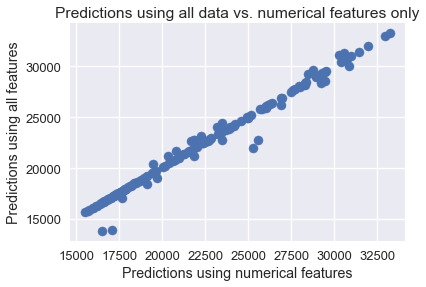

In [157]:
plt.scatter(simple_classifier.predict(X), clf.predict(encoded_X))
plt.title('Predictions using all data vs. numerical features only')
plt.xlabel('Predictions using numerical features')
plt.ylabel('Predictions using all features');

## Model Diagnosis

Why might this be the case? We can examine the parameters that both models learn. The table below shows the weights learned by the classifier that only used numerical variables without one-hot encoding:

In [172]:
# HIDDEN
def clf_params(names, clf):
    weights = (
        np.append(clf.coef_, clf.intercept_)
    )
    return pd.DataFrame(weights, names + ['Intercept'])

clf_params(numerical_columns, simple_classifier)

,0
Temperature,-332.221180
Fuel_Price,1626.625604
Unemployment,1356.868319
Intercept,29642.700510


The table below shows the weights learned by the classifier with one-hot encoding.

In [173]:
# HIDDEN
pd.options.display.max_rows = 13
display(clf_params(encoder.feature_names_, clf))
pd.options.display.max_rows = 7

,0
Fuel_Price,1622.106239
IsHoliday=No,-2.041451
IsHoliday=Yes,2.041451
MarkDown=MarkDown1,962.908849
MarkDown=MarkDown2,1805.059613
MarkDown=MarkDown3,-1748.475046
MarkDown=MarkDown4,-2336.799791
MarkDown=MarkDown5,215.060616
MarkDown=No Markdown,1102.245760
Temperature,-330.912587


We can see that even when we fit a linear regression model using one-hot encoded columns the weights for fuel price, temperature, and unemployment are very similar to the previous values. All the weights are small in comparison to the intercept term, suggesting that most of the variables are still only slightly correlated with the actual sale amounts. In fact, the model weights for the `IsHoliday` variable are so low that it makes nearly no difference in prediction whether the date was a holiday or not. Although some of the `MarkDown` weights are rather large, many markdown events only appear a few times in the dataset.

In [175]:
walmart['MarkDown'].value_counts()

No Markdown    92
MarkDown1      25
MarkDown2      13
MarkDown5       9
MarkDown4       2
MarkDown3       2
Name: MarkDown, dtype: int64

This suggests that we probably need to collect more data in order for the model to better utilize the effects of markdown events on the sale amounts. (In reality, the dataset shown here is a small subset of a [much larger dataset](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting) released by Walmart. It will be a useful exercise to train a model using the entire dataset instead of a small subset.)

## Summary

We have learned to use one-hot encoding, a useful technique for conducting linear regression on categorical data. Although in this particular example the transformation didn't affect our model very much, in practice the technique is used widely when working with categorical data. One-hot encoding also illustrates the general principle of feature engineering—it takes an original data matrix and transforms it into a potentially more useful one.